# MNIST

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

- 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음
- 28 x 28 배열로 크기를 바꾸고 imshow() 함수를 사용해 그려보겠음

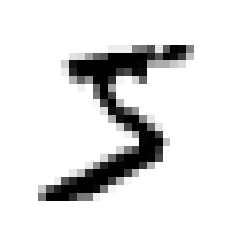

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [14]:
# 실제 레이블
y[0]

'5'

In [15]:
# y를 정수로 변환
y = y.astype(np.uint8)

- 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야함

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[600000:]

- 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦
- 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐
- 데이터셋을 섞으면 이런 문제를 방지할 수 있음

# 이진 분류기 훈련

두 개의 클래스를 구분할 수 있는 **이진 분류기**

In [17]:
y_train_5 = (y_train == 5) # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

- 사이킷런의 SGDClassifier 클래스를 사용해 **확률적 경사 하강법** 분류기로 시작해보는 것도 나쁘지 않음
- 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있음
- SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

- SGDClassifier는 훈련하는 데 무작위성을 사용함
- 결과를 재현하고 싶다면 random_state를 사용해야함

In [19]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

- 이 미지가 5를 나타낸다고 추측하였음

# 성능 측정

## 교차 검증을 사용한 정확도 측정

- 교차 검증은 모델을 평가하는 좋은 방법임

---
**교차 검증 구현**

- 교차 검증 과정을 더 많이 제어해야 할 필요가 있음
- 교차 검증 기능을 직접 구현하면 됨

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  # print(np.array(X_train.iloc[0]))
  X_train_folds = np.array(X_train.iloc[train_index])
  y_train_folds = y_train_5[train_index]
  X_test_fold = np.array(X_train.iloc[test_index])
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold) 
  print(n_correct / len(y_pred)) # 0.9502, 0.96565, 0.96495 출력

0.9669
0.91625
0.96785


- StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함

- 매 반복해서 분류기 객체를 복제하여 훈련 폴드를 훈련시키고 테스트 폴드로 예측을 만듦
  - 그 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력

- cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가해보겠음
- k-겹 교차 검증은 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용함

In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 교차 검증 폴드에 대해 **정확도** 가 95% 이상임

- 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보겠음

In [22]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

<font color="red">이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌</font>

**불균형한 데이터셋**을 다룰 때 더욱 그럼

## 오차 행렬

- 분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬**을 조사하는 것임
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것임
- 예를 들어 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 됨

- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
- 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 됨

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함
  - 즉 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨

- 이제 confusion_matrix() 함수를 사용해 오차 행렬을 만들 준비가 되어있음
- 타깃 클래스 (y_train_5)와 예측 클래스 (y_train_pred)를 넣고 호출하면 됨

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타냄

- 첫 번째 행은 '5 아님' 이미지에 대한 것 (**음성 클래스**)
  - 53892를 '5 아님'으로 정확하게 분류 (**진짜 음성**), 687를 잘못 분류(**거짓 양성**)

- 두 번째 행은 '5'이미지에 대한 것 (**양성 클래스**)
  - 1325를 '5 아님'으로 잘못 분류 (**거짓 음성**), 4096를 정확하게 분류(**진짜 양성**)

- 완벽한 분류기라면 주대각선만 0이 아닌 값이 됨

In [26]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 지표로는 양성 예측의 정확도를 사용 : **정밀도**

$$정밀도 = \frac{TP}{TP+FP}$$


- TP는 진짜 양성의 수고 FP는 거짓 양성의 수임
- 확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만, 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 그리 유용하지 않음

- 정밀도는 **재현율** 이라는 또 다른 지표와 같이 사용하는 것이 일반적임
- 재현율은 분류기가 정확하게 감지한 양성 샘플의 비율, **민감도**, 또는 **진짜 양성 비율(TPR)** 이라고도 함

$$재현율 = \frac{TP}{TP+FN}$$

- FN은 거짓 음성의 수

## 정밀도와 재현율

In [27]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

- 5로 판별된 이미지 중 72.9%만 정확함
  - 전체 숫자 5에서 75.6%만 감지했음

- 정밀도와 재현율을 **F1** 라고 하는 하나의 숫자로 만들면 편리할 때가 많음
- F1 점수는 정밀도와 재현율의 **조화 평균** 임

$$F_1 = \frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}} = 2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

- F1 점수를 계산하려면 f1_score()함수를 호출하면 됨

In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음

<font color='red'>정밀도 / 재현율 트레이드오프 </font>

- 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지임
- 둘다 높일 수 없음

## 정밀도/재현율 트레이드오프

- SGDClassifier가 분류를 어떻게 결정하는지 이해해보겠음
- 이 분류기는 **결정 함수** 를 사용하여 각 샘플의 점수를 계산함
  - 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당
  - 임곗값에 따라 결과가 달라짐
- 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있음
- decision_function()을 사용하여 샘플의 점수를 얻을 수 있음

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- 임곗값을 높여보겠음

In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임곗값을 높이면 재현율이 줄어듦
---
적절한 임곗값 정하기
- cross_val_predict() 함수를 통해 훈련 세트에 있는 모든 샘플의 점수를 구함
- 예측결과가 아닌 결정 점수를 반환받도록 지정해야함

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

- 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있음

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

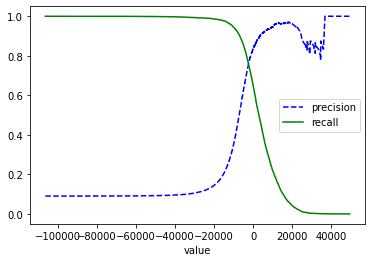

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="recall")
  plt.legend()
  plt.xlabel('value')
  # plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 정말 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것임

- 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함
  - 이 하강점 근처로 선택하는 것이 좋음

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] # ~7816

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

- 정밀도 90%를 달성한 분류기를 만들어보았음

## ROC 곡선

**수신기 조작 특성 (ROC)** 곡선도 이진 분류에서 널리 사용하는 도구임

- 거짓 양성 비율 (FPR)에 대한 진짜 양성 비율 (TPR, 재현율의 다른 이름)의 곡선임
  - 양성으로 질못 분류된 음성 샘플의 비율이 FPR임
  - 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율 (TNR)을 뺀 값임
  - TNR을 **특이도**라고도 함

- ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프임

$$FPR = \frac{FP}{FP+TN} = \frac{FP+TN-TN}{FP+TN} = 1 - \frac{TN}{FP+TN} = 1 - TNR$$


---
- ROC 곡선을 그리려면 먼저 roc_curve() 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야함

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

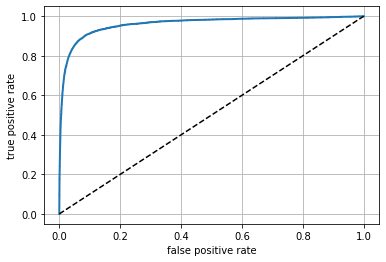

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label = label)
  plt.plot([0,1],[0,1],'k--') #대각 점선
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.grid(axis='both')

plot_roc_curve(fpr, tpr)
plt.show()

- 트레이드 오프 존재함
  - 재현율 (TPR)이 높을수록 분류기가 만드는 거짓 양성 (FPR)이 늘어남
- 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함

**좋은 분류기는 이 점선에서 최대한 떨어져 있어야 함(왼쪽 위 모서리)**

**곡선 아래의 면적 (AUC)을 측정하면 분류기들을 비교할 수 있음**

- 완벽한 분류기는 ROC의 AUC가 1임, 완전한 랜덤 분류기는 0.5임

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해보겠음

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

- roc_curve() 함수로 레이블과 점수를 기대함
  - 하지만 점수 대신에 클래스 확률을 전달할 수 있음

In [44]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용함
fpr_forest, tpr_forest, thesholds_forest = roc_curve(y_train_5, y_scores_forest)

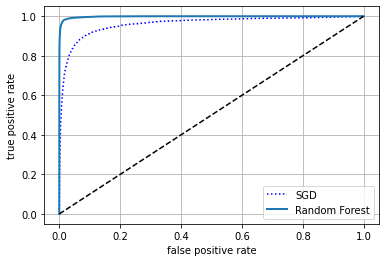

In [45]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend()
plt.show()

- RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워서 SGDClassifier가 훨씬 좋아보임
- ROC AUC 점수도 훨씬 높았음

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 다중 분류

**다중 분류기(다항 분류기)**

- 둘 이상의 클래스를 구별할 수 있음
- (SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 같은) 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있음
  - (로지스틱 회귀나 서포트 벡터 머신 분류기) 알고리즘은 이진 분류만 가능함
- 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음

- 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 됨
  - 이를 OvR 전략이라고 함 (또는 OvA)
- 또한 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련하는 것임
  - 이를 OvO 전략이라고 함
  - 클래스가 N개 라면 분류기는 N * (N-1)/2개가 필요함
---
- OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것임
- 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호함
  - 하지만 대부분은 OvR을 선호함

In [47]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용함
svm_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

- decision_function()을 사용하면 샘플당 10개의 점수를 반환함

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
np.argmax(some_digit_scores)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

- OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용함

In [52]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local

array([5], dtype=uint8)

In [53]:
len(ovr_clf.estimators_)

10

In [54]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

- SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 OvR이나 OvO를 적용할 필요가 없음

In [55]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 5의 점수가 압도적으로 높음

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- 입력의 스케일을 조정하여 더 높은 정확도를 확보할 수 있음

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석

모델의 성능을 향상시킬 방법을 찾아보겠음

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

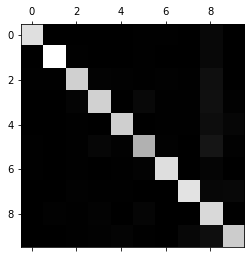

In [59]:
# matshow()로 시각화
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 잘 분류되었는지에 대한 확인은 주대각선임
- 숫자 5는 다른 숫자보다 조금 어두움 
  - 잘 분류하지 못했다는 뜻임
---
- 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교함

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

- 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그림

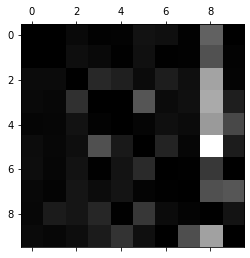

In [61]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 여러 분류기가 만든 에러를 확실히 볼 수 있음
- 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄
- 클래스 8의 열이 상당히 밝으므로 이미지가 8로 잘못 분류되었음을 암시함
- 하지만 클래스 8의 행은 그리 나쁘지 않아 8이 적절히 8로 분류되었다는 것을 볼 수 있음
- 3과 5가 많이 혼동되는 것을 볼 수 있음

**즉, 오차 행렬은 반드시 대칭인 것은 아님**

- 이 그래프를 보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있음
  - 더 많은 학습 데이터를 준비하던가
  - 동심원의 수를 세는 알고리즘 적용
---
- 샘플 그려봐 시각화함

NameError: ignored

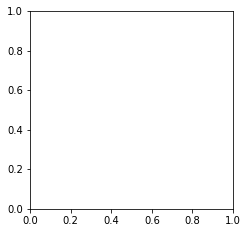

In [62]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


- 왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지, 오른쪽 5x5 블록 두 개는 5로 분류된 이미지임
- 원인은 선형 모델인 SGDClassifier를 사용했기 때문임
- 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함
  - 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동함

---
- 3과 5의 주요 차이는 왼쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치임
- 에러를 줄이는 방법으로 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것임


# 다중 레이블 분류

여러 개의 이진 꼬리표를 출력하는 분류 시스템인 **다중 레이블 분류**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

- 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만듦

In [ ]:
knn_clf.predict([some_digit])

---
다중 레이블 분류기를 평가하는 방법


In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

- 위 코드는 모든 레이블의 가중치가 같다고 가정한 것임
- 레이블에 클래스의 지지도(support, 즉 타깃 레이블에 속한 샘플 수)를 가중치로 주는 것임
  - average="weighted"로 바꾸면 됨

# 다중 출력 분류

**다중 출력 다중 클래스 분류**

- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것임
---
이미지 잡음을 제거하는 시스템을 만들어 보겠음

- 이 또한 다중 출력 레이블임


In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

- 테스트 이미지를 하나 선택해서 깨끗한 타깃 이미지로 만들어보겠음

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)